# Some Initialisation
## _(btw. Yes, I know. My Data has an Error since I added a Second City in the first headline for testing, and never changed it back)_

In [1]:
#
#  Imports and base Data Version 1.75
#

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from unidecode import unidecode 
from sklearn.cluster import KMeans
from mpl_toolkits.basemap import Basemap
from sklearn.cluster import DBSCAN

from math import cos, sin, asin


base_data = pd.read_csv(r'solution_3.csv')

helper_colors = ["lawngreen",
"chartreuse",
"lime",
"green",
"darkgreen",
"yellowgreen",
"springgreen",
"lightgreen",
"palegreen",
"mediumseagreen",
"seagreen",
"darkolivegreen",
"olivedrab",
"cyan",
"aqua",
"mediumaquamarine",
"paleturquoise",
"mediumturquoise",
"darkturquoise",
"lightseagreen",
"darkcyan",
"teal",
"thistle",
"violet",
"orchid",
"fuchsia",
"magenta",
"mediumorchid",
"mediumpurple",
"blueviolet",
"darkviolet",
"darkorchid",
"darkmagenta",
"purple",
"indig",]
#['indigo', 'lime', 'khaki', 'grey', 'lightblue', 'yellow', 'red', 'blue']




## Clean up the Data a little

  * Remove country column
  * Remove cluster column
  

In [2]:
base_data = base_data.drop(columns=['countries', 'cluster'])

print(base_data.head(2))

                                 headline                cities  longitude  \
0  Zika New York City Outbreak Hits Miami  New York City, Miami  -74.00597   
1         Could Zika Reach New York City?         New York City  -74.00597   

   latitude countrycode  
0  40.71427          US  
1  40.71427          US  


## Workflow Step 1
### Separate the data into world and US datasets _(since I cleaned the data up in Chapter 3, I have less to do)_

#### Sample Data from the Base DataSet

In [3]:
print(base_data[['headline','cities', 'countrycode']].head(10))
print()
print(base_data.count())

                                  headline                cities countrycode
0   Zika New York City Outbreak Hits Miami  New York City, Miami          US
1          Could Zika Reach New York City?         New York City          US
2        First Case of Zika in Miami Beach           Miami Beach          US
3  Mystery Virus Spreads in Recife, Brazil                Recife          BR
4  Dallas man comes down with case of Zika                Dallas          US
5        Trinidad confirms first Zika case              Trinidad          BO
6   Zika Concerns are Spreading in Houston               Houston          US
7    Geneve Scientists Battle to Find Cure                Geneve          CH
8    The CDC in Atlanta is Growing Worried               Atlanta          US
9       Zika Infested Monkeys in Sao Paulo             Sao Paulo          BR

headline       650
cities         612
longitude      612
latitude       612
countrycode    612
dtype: int64


#### Headlines with no country found

Some headlines could maybe be added into the list, but this could/will be done later. _(if there is time)_

In [4]:
no_country_code = base_data[base_data.countrycode.isnull()]

print(no_country_code.head(10))
print()
print(no_country_code.count())

                                              headline cities  longitude  \
19                 Zika infects pregnant woman in Cebu    NaN        NaN   
48                      Spanish Flu Sighted in Antigua    NaN        NaN   
73                          Zika case reported in Oton    NaN        NaN   
76   Hillsborough uses innovative trap against Zika...    NaN        NaN   
88            Maka City Experiences Influenza Outbreak    NaN        NaN   
156            West Nile Virus Outbreak in Saint Johns    NaN        NaN   
234                         Malaria Exposure in Sussex    NaN        NaN   
248              Greenwich Establishes Zika Task Force    NaN        NaN   
252         Will West Nile Virus vaccine help Parsons?    NaN        NaN   
257          Yulee takes a hit from Spreading Sickness    NaN        NaN   

     latitude countrycode  
19        NaN         NaN  
48        NaN         NaN  
73        NaN         NaN  
76        NaN         NaN  
88        NaN         N

#### Headlines for US

In [5]:
us_headlines_df = base_data[base_data['countrycode'] == 'US']

print(us_headlines_df.head(10))
print()
print(us_headlines_df.count())

                                             headline                cities  \
0              Zika New York City Outbreak Hits Miami  New York City, Miami   
1                     Could Zika Reach New York City?         New York City   
2                   First Case of Zika in Miami Beach           Miami Beach   
4             Dallas man comes down with case of Zika                Dallas   
6              Zika Concerns are Spreading in Houston               Houston   
8               The CDC in Atlanta is Growing Worried               Atlanta   
10              Brownsville teen contracts Zika virus           Brownsville   
11  Mosquito control efforts in St. Louis take new...             St. Louis   
13                   Flu outbreak in Galveston, Texas    Galveston, Houston   
16               New Los Angeles Hairstyle goes Viral           Los Angeles   

    longitude  latitude countrycode  
0   -74.00597  40.71427          US  
1   -74.00597  40.71427          US  
2   -80.13005  2

#### Headlines for Rest of the world

In [6]:
world_headlines_df = base_data[(base_data['countrycode'] != 'US') & base_data.countrycode.notna()]
print(world_headlines_df.head(10))
print()
print(world_headlines_df.count())

                                             headline            cities  \
3             Mystery Virus Spreads in Recife, Brazil            Recife   
5                   Trinidad confirms first Zika case          Trinidad   
7               Geneve Scientists Battle to Find Cure            Geneve   
9                  Zika Infested Monkeys in Sao Paulo         Sao Paulo   
12  San Juan reports 1st U.S. Zika-related death a...          San Juan   
14                 Zika alert – Manila now threatened            Manila   
15                     Zika afflicts 7 in Iloilo City            Iloilo   
24          London Health Unit Tracks Mad Cow Disease            London   
25     Zika cases in Vietnam's Ho Chi Minh City surge  Ho Chi Minh City   
28            Scientists in Paris to look for answers             Paris   

    longitude  latitude countrycode  
3   -34.88111  -8.05389          BR  
5   -64.90000 -14.83333          BO  
7     6.14569  46.20222          CH  
9   -46.63611 -23.5475

## Workflow Step 2
### Re-cluster the world and US data separately

#### Setup Functions for Displaying Cluster Data

In [7]:

def draw_us_map():
    map = Basemap(width=10000000,height=4000000,projection='lcc', resolution='c',lat_0=40,lon_0=-100)
    map.drawcoastlines()
    map.drawcountries()
    return map

def draw_world_map():
    map = Basemap()
    map.drawcoastlines()
    map.drawcountries()
    return map

def draw_point_on_map(map, locations, colors):

    for i in range(len(locations)):
        color = colors[i]
        lat = locations[i][1]
        long = locations[i][0]
        map.scatter([long], [lat], color=color, latlon=True, s=50)

def get_kmeans_inertia_values_for_locations(locations, k_values):
    return [KMeans(k).fit(locations).inertia_ for k in k_values]

def display_result_layout(titel, df, clusters_prediction_count, colors, is_us):
    locations = df[['longitude','latitude']].values
    
    k_values = range(1, 50)
    base_colors_for_clusters = colors[1:]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,8),  gridspec_kw={'width_ratios': [3, 6]})
    fig.suptitle(titel)
    
    inertia_values = get_kmeans_inertia_values_for_locations(locations, k_values)
    location_clusters = KMeans(clusters_prediction_count).fit_predict(locations)

    cluster_colors = [base_colors_for_clusters[cluster] for cluster in  location_clusters]

    ax1.plot(k_values, inertia_values, colors[0])
    
    if is_us:
        map = draw_us_map()
    else:
        map = draw_world_map()
        
    draw_point_on_map(map, locations, cluster_colors)
    plt.show()
    
    return pd.Series(location_clusters)


### US Clusters, Cluster prediction 10, since I tried some values and this seems good spread

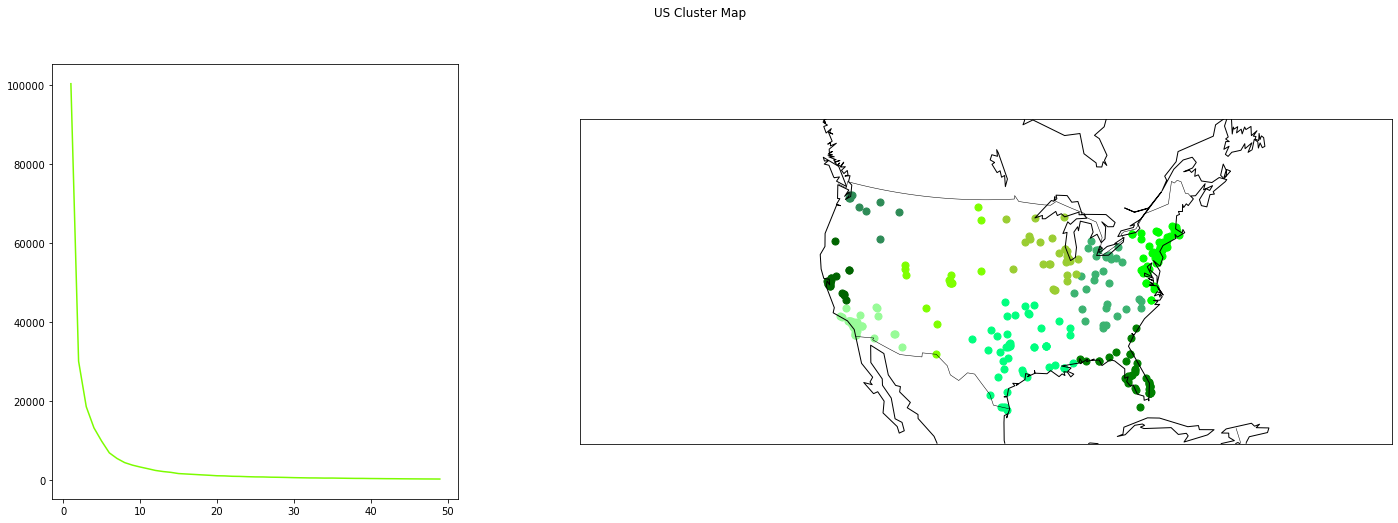

                                             headline                cities  \
0              Zika New York City Outbreak Hits Miami  New York City, Miami   
1                     Could Zika Reach New York City?         New York City   
2                   First Case of Zika in Miami Beach           Miami Beach   
4             Dallas man comes down with case of Zika                Dallas   
6              Zika Concerns are Spreading in Houston               Houston   
8               The CDC in Atlanta is Growing Worried               Atlanta   
10              Brownsville teen contracts Zika virus           Brownsville   
11  Mosquito control efforts in St. Louis take new...             St. Louis   
13                   Flu outbreak in Galveston, Texas    Galveston, Houston   
16               New Los Angeles Hairstyle goes Viral           Los Angeles   

    longitude  latitude countrycode  cluster  
0   -74.00597  40.71427          US      1.0  
1   -74.00597  40.71427          US 

In [8]:
clusters_prediction_count = 10
custer_new = display_result_layout('US Cluster Map', us_headlines_df, clusters_prediction_count, helper_colors, True)
us_output = us_headlines_df.copy(deep=True)

us_output['cluster'] = custer_new

print(us_output.head(10))


### World (without US ) Clusters, with Cluster prediction 21 ( ~ 3 per continent)  

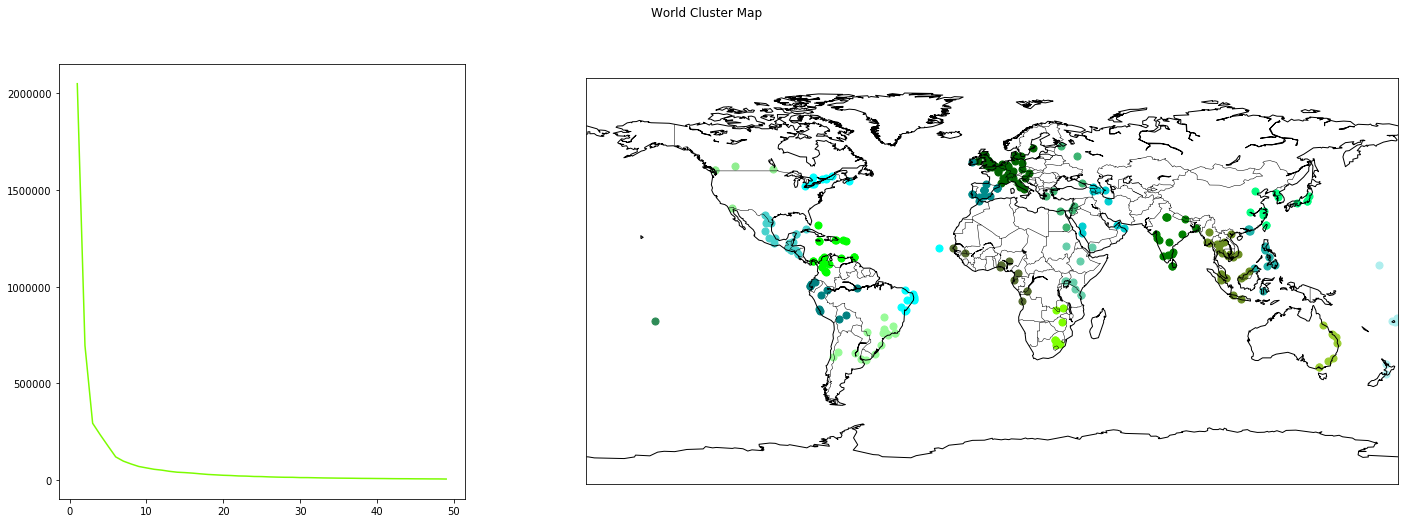

                                             headline            cities  \
3             Mystery Virus Spreads in Recife, Brazil            Recife   
5                   Trinidad confirms first Zika case          Trinidad   
7               Geneve Scientists Battle to Find Cure            Geneve   
9                  Zika Infested Monkeys in Sao Paulo         Sao Paulo   
12  San Juan reports 1st U.S. Zika-related death a...          San Juan   
14                 Zika alert – Manila now threatened            Manila   
15                     Zika afflicts 7 in Iloilo City            Iloilo   
24          London Health Unit Tracks Mad Cow Disease            London   
25     Zika cases in Vietnam's Ho Chi Minh City surge  Ho Chi Minh City   
28            Scientists in Paris to look for answers             Paris   

    longitude  latitude countrycode  cluster  
3   -34.88111  -8.05389          BR      7.0  
5   -64.90000 -14.83333          BO     18.0  
7     6.14569  46.20222          

In [9]:
clusters_prediction_count = 21
custer_new = display_result_layout('World Cluster Map', world_headlines_df, clusters_prediction_count, helper_colors, False)
world_output = world_headlines_df.copy(deep=True)

world_output['cluster'] = custer_new

print(world_output.head(10))

## Workflow Step 3
### Sort the clusters by the number of headlines from largest to smallest


#### US Sorted Data


In [10]:
us_output_cluster_count = us_output.groupby(['cluster'])['longitude', 'latitude'].agg(longitude_mean=('longitude', 'mean'), 
                               latitude_mean=('latitude', 'mean'),headline_count=('longitude', 'count'))
us_output = us_output.merge(us_output_cluster_count, left_on='cluster', right_on='cluster').sort_values(['headline_count'], ascending=False)

print(us_output.head(10))

                                             headline                cities  \
0              Zika New York City Outbreak Hits Miami  New York City, Miami   
27                How to Avoid Hepatitis B in Waldorf               Waldorf   
20                    Syphilis Outbreak in Harrisburg            Harrisburg   
21    Urbana Encounters Severe Symptoms of Meningitis                Urbana   
22     Pittsburgh Residents Recieve Norovirus vaccine            Pittsburgh   
23                    Hepatitis C Outbreak in Danbury               Danbury   
24                            Syphilis Hits Jefferson             Jefferson   
25  Authorities are Worried about the Spread of Ro...                 Union   
28     Zika-carrying mosquitoes discovered in Ardmore               Ardmore   
18                   Hepatitis B Comes to Kansas City  Kansas City, Wichita   

    longitude  latitude countrycode  cluster  longitude_mean  latitude_mean  \
0   -74.00597  40.71427          US      1.0      -

#### World Sorted Data

In [11]:

world_output_cluster_count = world_output.groupby(['cluster'])['longitude', 'latitude'].agg(longitude_mean=('longitude', 'mean'), 
                               latitude_mean=('latitude', 'mean'),headline_count=('longitude', 'count'))
world_output = world_output.merge(world_output_cluster_count, left_on='cluster', right_on='cluster').sort_values(['headline_count'], ascending=False)

print(world_output.head(10))


                                          headline         cities  longitude  \
37              Zika reaches Johor Bahru, Malaysia    Johor Bahru  103.75780   
25              Zika Infested Monkeys in Sao Paulo      Sao Paulo  -46.63611   
27                            Caracas patient dies        Caracas  -66.87919   
29                   Spreading Zika reaches Bacoor         Bacoor  120.93851   
30  Tokyo Encounters Severe Symptoms of Meningitis          Tokyo  139.69171   
31                     Rabies Exposure in Hamilton       Hamilton  -79.84963   
32                      Zika Outbreak in Hyderabad      Hyderabad   78.45636   
33                        Is Zika virus in Majuro?         Majuro  171.38027   
34          Cancun hit by Outbreak of Party Fever!         Cancun  -86.84656   
35                 Villavicencio under Zika threat  Villavicencio  -73.62664   

    latitude countrycode  cluster  longitude_mean  latitude_mean  \
37   1.46550          MY      3.0       20.632618  

#### Function for calculating the distance

In [12]:
def great_circle_distance(x1, y1, x2, y2):
    delta_x, delta_y = x2 - x1, y2 - y2
    haversin = sin(delta_x / 2) ** 2 + np.product([cos(x1), cos(x2), sin(delta_y / 2) ** 2])
    return 2 * asin(haversin ** 0.5)

def travel_distance (lat1, lon1, lat2, lon2):
    to_radians =  np.radians([lat1, lon1, lat2, lon2])
    return 3956 * great_circle_distance(*to_radians.tolist())


#### Sort Cluster by cluster & distance US

In [13]:

us_output['distance_2_center'] = us_output.apply (lambda row: round(travel_distance(row['latitude'], row['longitude'],row['latitude_mean'], row['longitude_mean']), 2) \
            , axis=1)

us_output = us_output.sort_values(['headline_count', 'distance_2_center'], ascending=[False, True])
print(us_output.head(10))



                                             headline                cities  \
18                   Hepatitis B Comes to Kansas City  Kansas City, Wichita   
11  New medicine wipes out West Nile Virus in Ventura               Ventura   
28     Zika-carrying mosquitoes discovered in Ardmore               Ardmore   
2                New Los Angeles Hairstyle goes Viral           Los Angeles   
27                How to Avoid Hepatitis B in Waldorf               Waldorf   
9                          HIV has Arrived in Fairfax               Fairfax   
13  Rumors about Hepatitis D Spreading in San Juan...   San Juan Capistrano   
24                            Syphilis Hits Jefferson             Jefferson   
30    Rotavirus Vaccine is now Required in Starkville            Starkville   
17  Escondido neighborhood to get sprayed for Zika...             Escondido   

    longitude  latitude countrycode  cluster  longitude_mean  latitude_mean  \
18  -97.33754  37.69224          US      1.0      -

#### Sort Cluster by cluster & distance World

In [14]:
world_output['distance_2_center'] = world_output.apply (lambda row: round(travel_distance(row['latitude'], row['longitude'],row['latitude_mean'], row['longitude_mean']), 2) \
            , axis=1)

world_output = world_output.sort_values(['headline_count', 'distance_2_center'], ascending=[False, True])
print(world_output.head(10))

                                    headline         cities  longitude  \
32                Zika Outbreak in Hyderabad      Hyderabad   78.45636   
29             Spreading Zika reaches Bacoor         Bacoor  120.93851   
28               Zika arrives in Tegucigalpa    Tegucigalpa  -87.20681   
34    Cancun hit by Outbreak of Party Fever!         Cancun  -86.84656   
42      Mecca tests new cure for Chikungunya          Mecca   39.82563   
38                   Nha Trang Zika Outbreak      Nha Trang  109.19432   
27                      Caracas patient dies        Caracas  -66.87919   
45      Four cases of Zika in Hidalgo County        Hidalgo -100.45029   
33                  Is Zika virus in Majuro?         Majuro  171.38027   
36  New Zika Case in Kota Kinabalu, Malaysia  Kota Kinabalu  116.07240   

    latitude countrycode  cluster  longitude_mean  latitude_mean  \
32  17.38405          IN      3.0       20.632618      17.397922   
29  14.45896          PH      3.0       20.632618

## Workflow Step 5
### Examine the headlines closest to the center of each cluster.

### US Just get the Top 5 of every group and check for diseases

_I set the max display rows in panda to 105, so that I can see then data of every cluster_

In [15]:
pd.set_option('display.max_rows', 105)
us_output.sort_values(['cluster', 'headline_count', 'distance_2_center'], ascending=[True,False, True]).groupby('cluster')['cluster', 'headline', 'headline_count', 'distance_2_center'].head(5)

,cluster,headline,headline_count,distance_2_center
119,0.0,More people in Mclean are infected with Hepati...,7,71.22
118,0.0,Will HIV vaccine help Las Vegas?,7,119.29
117,0.0,Chikungunya Hits Denver,7,126.80
114,0.0,Flu season hits Boston,7,307.65
120,0.0,Zika symptoms spotted in Arlington,7,356.76
18,1.0,Hepatitis B Comes to Kansas City,34,104.76
11,1.0,New medicine wipes out West Nile Virus in Ventura,34,130.95
28,1.0,Zika-carrying mosquitoes discovered in Ardmore,34,138.14
2,1.0,New Los Angeles Hairstyle goes Viral,34,146.56
27,1.0,How to Avoid Hepatitis B in Waldorf,34,169.13


### World Just get the Top 5 of every group and check for diseases

In [16]:
world_output.sort_values(['cluster', 'headline_count', 'distance_2_center'], ascending=[True,False, True]).groupby('cluster')['cluster', 'headline', 'headline_count', 'distance_2_center'].head(5)

,cluster,headline,headline_count,distance_2_center
140,0.0,Hepatitis B Vaccine is now Required in Quebec,4,469.96
141,0.0,Sick Livestock Leads to Serious Trouble for Be...,4,527.26
142,0.0,Will Meningitis vaccine help Hamburg?,4,936.91
143,0.0,Zika Troubles come to Kampong Cham,4,1934.12
103,1.0,Zika spreads to Barranquilla,11,4.92
100,1.0,Outbreak of Zika in Bacolod City,11,25.77
94,1.0,First Zika case confirmed in Yangon,11,398.08
95,1.0,Hospitals in Hanoi fill up with Zika patients,11,689.39
99,1.0,Spreading Zika ruining Cancun fun,11,699.73
110,2.0,More Zika patients reported in Davao,7,48.71


## Workflow Step 6
### Pinpoint disease outbreaks based on repeated diseases within headlines in clusters

### _To speed up the Process I searched for diseases_

#### Prepare to remove all words that are cities, countries

In [17]:
replace_cities = "|".join([x["cities"] for i,x in base_data[["cities"]].iterrows() if not isinstance(x["cities"], float)]).replace(".", "\\.").replace(", ",",").replace(" ","|")
fullregex_replace_string = replace_cities 

#### Find "words" that could be the name of a disease

In [18]:
words = []

for idx, row in base_data[["headline"]].iterrows():
    headline = unidecode(row.get("headline"))
    helper = re.sub(fullregex_replace_string, "", headline)
    helper = re.findall(r"[A-Z](?:\w|\W)+?\b", helper)
    words = words + helper

#### Remove words shorter than 2

In [19]:
words = [ word for word in words if len(word) > 2]

#### After Checking (by Hand) the results, I create a list of words that are no Diseases

In [20]:
data = pd.DataFrame({"words" : words, "helper": range(len(words))})
data.sort_values(by=['words'])
data = data.groupby("words").count().reset_index().sort_values(by=['helper'], ascending=False)
data.head(10)

,words,helper
240,Zika,227
146,Outbreak,60
91,Hepatitis,57
134,More,51
192,Spread,46
232,Virus,44
193,Spreading,30
203,Symptoms,26
224,Vaccine,24
176,Rumors,24


#### Identified non disease Words
##### _("Mad" was removed, not to have "Mad Cow" disease double, not optimal)_

In [21]:
ignore = ["Disease","Mad", "Mandatory", "Patients", "Getting","Contracting", "Condition", "Diagnosed", "Critical", "Recieve","Required","Exposure", "Refuted", "Closed","Schools","Due", "Patient", "Keeps", "Arrived", "Hits", "Confirmed", "Residents", "Avoid", "Encounters", "Outbreak", "More", "Spread", "Spreading", "Symptoms", "Authorities", "Worried", "Will", "Cases", "Case", "Spike", "Severe", "Rumors", "Vaccine", "Reported", "Severe"]
print("words that were ignored: " + str(len(ignore)))

words that were ignored: 40


#### Get words that have atleast 10 occurrences
##### _(could go lower, but than is probably not a epidemic)_

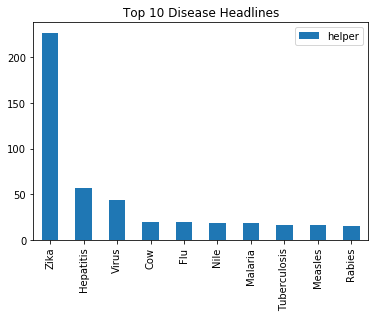

In [22]:
data = data[~ data["words"].isin(ignore)]
data = data.where(data["helper"] > 9)
data = data[~data["helper"].isna()]

data[["helper"]].head(10).plot.bar(title="Top 10 Disease Headlines")
_ = plt.xticks(np.arange(10), data["words"].head(10))

#### Check If words ["Mad","Cow"] are for the "Mad Cow" disease

In [23]:
mc_data = [row for idx, row in base_data.iterrows() if "Mad Cow" in row["headline"]]
m_data = [row for idx, row in base_data.iterrows() if "Mad" in row["headline"]]
c_data = [row for idx, row in base_data.iterrows() if "Cow" in row["headline"]]
print("MadCow Checks\n Mad Cow: % 3d\nOnly Cow: % 3d\nOnly Mad: % 3d" %(len(mc_data),len(c_data), len(m_data)))


MadCow Checks
 Mad Cow:  19
Only Cow:  19
Only Mad:  25


##### We can remove "Mad" from the list ...
###### _(IRL this should be checked better)_

### Recreate Clusters Images with filtered headlines US

#### Since there are less headline I also reduce the cluster size

_this was a bit of an overkill, sI will just filter for 'Zika' and 'Hepatitis' since < 50 mentions worldwide_

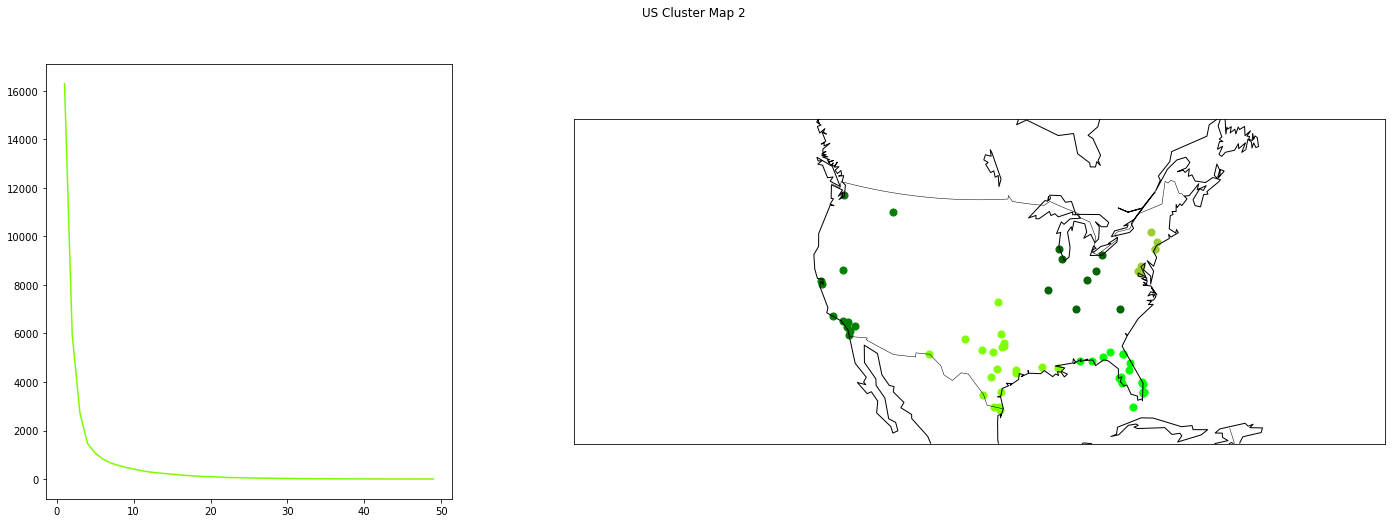

                                             headline                cities  \
0              Zika New York City Outbreak Hits Miami  New York City, Miami   
1                     Could Zika Reach New York City?         New York City   
2                   First Case of Zika in Miami Beach           Miami Beach   
4             Dallas man comes down with case of Zika                Dallas   
6              Zika Concerns are Spreading in Houston               Houston   
8               The CDC in Atlanta is Growing Worried               Atlanta   
10              Brownsville teen contracts Zika virus           Brownsville   
11  Mosquito control efforts in St. Louis take new...             St. Louis   
13                   Flu outbreak in Galveston, Texas    Galveston, Houston   
16               New Los Angeles Hairstyle goes Viral           Los Angeles   

    longitude  latitude countrycode  cluster  
0   -74.00597  40.71427          US      0.0  
1   -74.00597  40.71427          US 

In [24]:
# helper_re = "|".join(data["words"])
helper_re = 'Zika|Hepatitis'


# Could be optiomized, but I'm tired. (Yes, yes the whole notebook) :)

_valid_headlines_ =  [ row['headline'] for idx, row in us_output.iterrows() if re.search(helper_re, row["headline"])]

us_final_headline_df = us_output[us_output['headline'].isin(_valid_headlines_)]

clusters_prediction_count = 5
custer_new = display_result_layout('US Cluster Map 2', us_final_headline_df, clusters_prediction_count, helper_colors, True)
us_output = us_headlines_df.copy(deep=True)

us_output['cluster'] = custer_new

print(us_output.head(10))


### Recreate Clusters Images with filtered headlines US
#### Since there are less headline I also reduce the cluster size

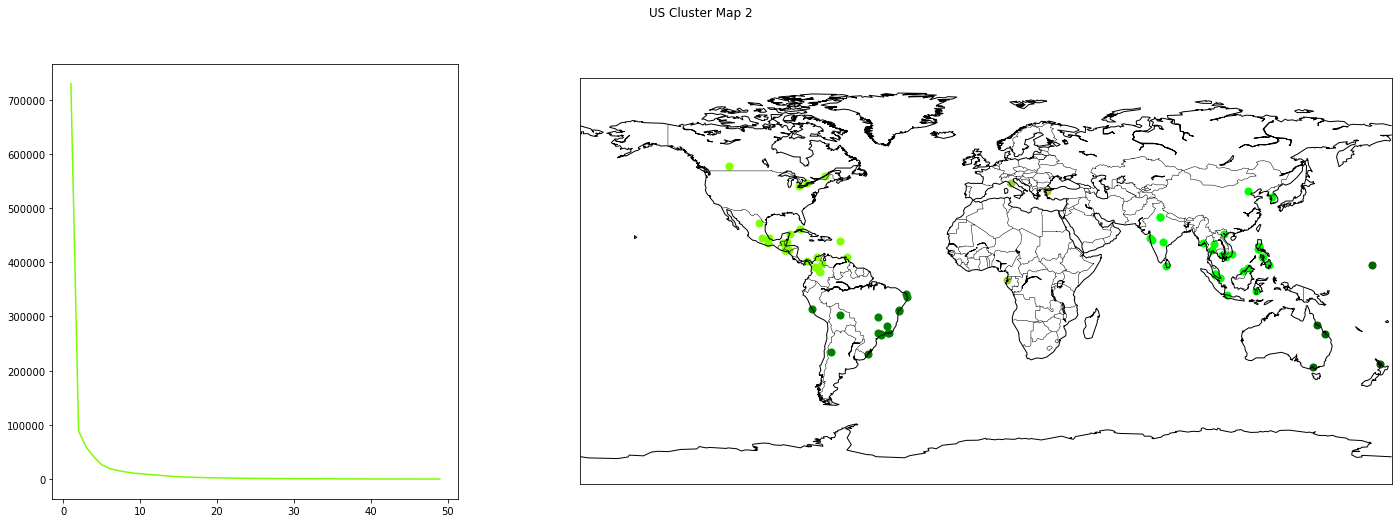

                                             headline            cities  \
3             Mystery Virus Spreads in Recife, Brazil            Recife   
5                   Trinidad confirms first Zika case          Trinidad   
7               Geneve Scientists Battle to Find Cure            Geneve   
9                  Zika Infested Monkeys in Sao Paulo         Sao Paulo   
12  San Juan reports 1st U.S. Zika-related death a...          San Juan   
14                 Zika alert – Manila now threatened            Manila   
15                     Zika afflicts 7 in Iloilo City            Iloilo   
24          London Health Unit Tracks Mad Cow Disease            London   
25     Zika cases in Vietnam's Ho Chi Minh City surge  Ho Chi Minh City   
28            Scientists in Paris to look for answers             Paris   

    longitude  latitude countrycode  cluster  
3   -34.88111  -8.05389          BR      1.0  
5   -64.90000 -14.83333          BO      3.0  
7     6.14569  46.20222          

In [25]:
_valid_headlines_ =  [ row['headline'] for idx, row in world_output.iterrows() if re.search(helper_re, row["headline"])]
world_final_headline_df = world_output[world_output['headline'].isin(_valid_headlines_)]

clusters_prediction_count = 5
custer_new = display_result_layout('US Cluster Map 2', world_final_headline_df, clusters_prediction_count, helper_colors, False)
wordl_output = world_headlines_df.copy(deep=True)

wordl_output['cluster'] = custer_new

print(wordl_output.head(10))
